## 数据预处理
- 得到v3版本数据
- 得到v4版本数据

### 导入数据

In [2]:
import pandas as pd
from collections import Counter

df_train = pd.read_csv('data/train.csv') # 训练集
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304888 entries, 0 to 304887
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304888 non-null  int64  
 1   Gender                304888 non-null  object 
 2   Age                   304888 non-null  int64  
 3   Driving_License       304010 non-null  float64
 4   Region_Code           304888 non-null  float64
 5   Previously_Insured    304888 non-null  int64  
 6   Vehicle_Age           304888 non-null  object 
 7   Vehicle_Damage        304888 non-null  object 
 8   Annual_Premium        304888 non-null  float64
 9   Policy_Sales_Channel  304007 non-null  float64
 10  Vintage               304888 non-null  int64  
 11  Response              304888 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 27.9+ MB


### 数据格式处理（未升维）

In [3]:
# 数据格式处理
num_feat = ['Age', 'Vintage', 'Annual_Premium'] # 数值属性
nor_feat = ['Gender', 'Driving_License', 'Region_Code', 'Vehicle_Damage',  'Vehicle_Age', 'Policy_Sales_Channel', 'Previously_Insured'] # 标称属性

# df_train.drop(['Unnamed: 0', 'way'], axis=1, inplace=True)

### 缺失值处理
写了三种方法，自行选择
* 删除含有空值的行
* 逻辑回归填充`Driving_License` + 轮盘法填充 `Policy_Sales_Channel`
* 全部轮盘法填充

#### 1、删除含有空值的行

In [3]:
# # 缺失值检测处理：删除含有空值的行（标称属性）
# df_train.dropna(axis=0, how='any', inplace=True)


#### 2、逻辑回归
*自行修改轮盘法`null_pro`*

In [4]:
# # 缺失值检测处理：逻辑回归（标称属性）

# # 划分缺失值行

# list_null = []
# list_notnull = []

# null_pro = ['Driving_License']
# for pro in null_pro:                        
#     for index in range(len(df_train[pro])):
#         if pd.isnull(df_train[pro][index]):
#             list_null.append(df_train[index:index+1])
#         else:
#             list_notnull.append(df_train[index:index+1])
# df_null = pd.concat(list_null)
# df_notnull = pd.concat(list_notnull)


In [5]:
# # 划分data、label
# train_dl = df_notnull["Driving_License"]
# train_data = df_notnull.drop(['Response', 'id', 'Driving_License', 'Policy_Sales_Channel'], axis = 1)

# test_data = df_null.drop(['Response', 'id', 'Driving_License', 'Policy_Sales_Channel'], axis = 1)

In [6]:
# # 调用逻辑回归
# from sklearn import linear_model
# lr = linear_model.LogisticRegression()
# lr.fit(train_data, train_dl)
# predict_dl = lr.predict(test_data)

# index_pdl = 0
# for pro in null_pro:                        
#     for index in range(len(df_train[pro])):
#         if pd.isnull(df_train[pro][index]):
#             df_train[pro][index] = predict_dl[index_pdl]
#             index_pdl += 1

# df_train.info()

#### 3、轮盘法

In [4]:
# 缺失值检测处理：轮盘法按概率填充（标称属性）
import random

null_pro = ['Driving_License', 'Policy_Sales_Channel']
for pro in null_pro:
    countPro = Counter([x for x in df_train[pro] if pd.isnull(x) == False])
    sumPro = sum(countPro.values())
    for index in range(len(df_train[pro])):
        if pd.isnull(df_train[pro][index]):
            needle = random.random() 
            needle *= sumPro
            for cur in countPro.most_common():
                needle -= cur[1]
                if needle <= 0:
                    df_train[pro][index] = cur[0]
                    break
df_train.info()

/home/haojie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304888 entries, 0 to 304887
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    304888 non-null  int64  
 1   Gender                304888 non-null  object 
 2   Age                   304888 non-null  int64  
 3   Driving_License       304888 non-null  float64
 4   Region_Code           304888 non-null  float64
 5   Previously_Insured    304888 non-null  int64  
 6   Vehicle_Age           304888 non-null  object 
 7   Vehicle_Damage        304888 non-null  object 
 8   Annual_Premium 

## 对PSC进行处理

In [8]:
import numpy as np

In [10]:
psc_min = np.int(np.min(df_train['Policy_Sales_Channel']))
psc_max = np.int(np.max(df_train['Policy_Sales_Channel']))
psc_counts = [ np.sum(df_train['Policy_Sales_Channel'] == i) for i in range(psc_min, psc_max+1)]
psc_sort = psc_counts.copy()
psc_sort.sort(reverse=True)
psc_threshold = psc_sort[2]


In [12]:
df_train['Policy_Sales_Channel'] = df_train['Policy_Sales_Channel'].astype('int')

In [13]:
psc_sort[:3]

[26989, 15901, 14820]

In [14]:
psc_cats = 3
train_psc = df_train['Policy_Sales_Channel'].copy()
for i in range(len(train_psc)):
    now_psc = train_psc[i]-1
    if (psc_counts[now_psc] >= psc_threshold):
        for j in range(psc_cats):
            if (psc_sort[j] == psc_counts[now_psc]):
                train_psc[i] = j+1
                break
    else:
        train_psc[i] = 0

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

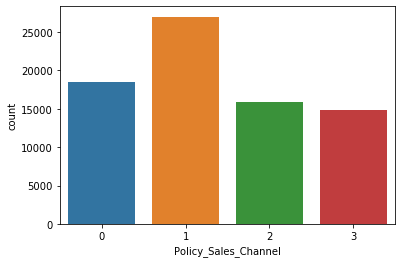

In [16]:
sns.countplot(train_psc)

In [17]:
train_psc.value_counts()

1    26989
0    18511
2    15901
3    14820
Name: Policy_Sales_Channel, dtype: int64

In [18]:
# df_train['Policy_Sales_Channel'] = train_psc
df_train['PSC_Plus'] = train_psc
df_train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,PSC_Plus
0,0,1,41,1.0,6.0,0,1-2 Year,Yes,36438.0,124,119,0,3
1,1,0,28,1.0,28.0,1,< 1 Year,No,44632.0,152,91,0,1
2,2,0,32,1.0,8.0,0,1-2 Year,Yes,36838.0,124,83,0,3
3,3,1,36,1.0,28.0,1,1-2 Year,No,30074.0,122,273,0,0
4,4,0,32,1.0,15.0,0,< 1 Year,Yes,38230.0,152,297,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,76216,0,46,1.0,3.0,0,> 2 Years,Yes,30714.0,26,148,0,2
76217,76217,0,37,1.0,0.0,0,1-2 Year,No,2630.0,61,143,0,0
76218,76218,1,33,1.0,49.0,1,< 1 Year,No,33553.0,152,267,0,1
76219,76219,1,72,1.0,28.0,0,> 2 Years,Yes,34283.0,124,284,0,3


In [19]:
df_train['PSC_Plus'] = df_train['PSC_Plus'].astype('str')
df_train=pd.get_dummies(df_train,drop_first=True)
df_train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,PSC_Plus_1,PSC_Plus_2,PSC_Plus_3
0,0,1,41,1.0,6.0,0,36438.0,124,119,0,0,0,1,0,0,1
1,1,0,28,1.0,28.0,1,44632.0,152,91,0,1,0,0,1,0,0
2,2,0,32,1.0,8.0,0,36838.0,124,83,0,0,0,1,0,0,1
3,3,1,36,1.0,28.0,1,30074.0,122,273,0,0,0,0,0,0,0
4,4,0,32,1.0,15.0,0,38230.0,152,297,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,76216,0,46,1.0,3.0,0,30714.0,26,148,0,0,1,1,0,1,0
76217,76217,0,37,1.0,0.0,0,2630.0,61,143,0,0,0,0,0,0,0
76218,76218,1,33,1.0,49.0,1,33553.0,152,267,0,1,0,0,1,0,0
76219,76219,1,72,1.0,28.0,0,34283.0,124,284,0,0,1,1,0,0,1


In [20]:
df_train.drop(['id'], axis=1, inplace=True)
df_train=df_train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_1_Year_down", "Vehicle_Age_> 2 Years": "Vehicle_Age_2_Years_up"})
df_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1_Year_down,Vehicle_Age_2_Years_up,Vehicle_Damage_Yes,PSC_Plus_1,PSC_Plus_2,PSC_Plus_3
0,1,41,1.0,6.0,0,36438.0,124,119,0,0,0,1,0,0,1
1,0,28,1.0,28.0,1,44632.0,152,91,0,1,0,0,1,0,0
2,0,32,1.0,8.0,0,36838.0,124,83,0,0,0,1,0,0,1
3,1,36,1.0,28.0,1,30074.0,122,273,0,0,0,0,0,0,0
4,0,32,1.0,15.0,0,38230.0,152,297,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,0,46,1.0,3.0,0,30714.0,26,148,0,0,1,1,0,1,0
76217,0,37,1.0,0.0,0,2630.0,61,143,0,0,0,0,0,0,0
76218,1,33,1.0,49.0,1,33553.0,152,267,0,1,0,0,1,0,0
76219,1,72,1.0,28.0,0,34283.0,124,284,0,0,1,1,0,0,1


### 后续数据处理

In [21]:
# 数据格式处理
df_train['Driving_License'] = df_train['Driving_License'].astype(int)
df_train['Region_Code'] = df_train['Region_Code'].astype(int)

### 标准化
*处理数值属性`num_feat`*

## 同样处理Region_Code

In [ ]:
rc_min = np.int(np.min(df_train['Region_Code']))
rc_max = np.int(np.max(df_train['Region_Code']))
rc_counts = [ np.sum(df_train['Region_Code'] == i) for i in range(rc_min, rc_max+1)]
psc_sort = psc_counts.copy()
psc_sort.sort(reverse=True)
psc_threshold = psc_sort[2]
rc_threshold = rc_sort[0]

In [24]:
train_rc = df_train['Region_Code'].copy()
for i in range(len(train_rc)):
    now_rc = train_rc[i]-rc_min
    if (rc_counts[now_rc] >= rc_threshold):
        for j in range(rc_cats):
            if (rc_sort[j] == rc_counts[now_rc]):
                train_rc[i] = j+1
                break
    else:
        train_rc[i] = 0
train_rc

0        0
1        1
2        0
3        1
4        0
        ..
76216    0
76217    0
76218    0
76219    1
76220    0
Name: Region_Code, Length: 76221, dtype: int32

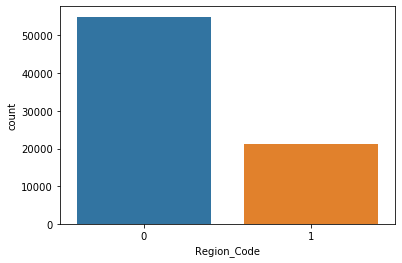

In [25]:
sns.countplot(train_rc)

In [26]:
df_train['RC_Plus'] = train_rc
df_train['RC_Plus'] = df_train['RC_Plus'].astype('str')
df_train=pd.get_dummies(df_train,drop_first=True)
df_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_1_Year_down,Vehicle_Age_2_Years_up,Vehicle_Damage_Yes,PSC_Plus_1,PSC_Plus_2,PSC_Plus_3,RC_Plus_1
0,1,41,1,6,0,36438.0,124,119,0,0,0,1,0,0,1,0
1,0,28,1,28,1,44632.0,152,91,0,1,0,0,1,0,0,1
2,0,32,1,8,0,36838.0,124,83,0,0,0,1,0,0,1,0
3,1,36,1,28,1,30074.0,122,273,0,0,0,0,0,0,0,1
4,0,32,1,15,0,38230.0,152,297,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76216,0,46,1,3,0,30714.0,26,148,0,0,1,1,0,1,0,0
76217,0,37,1,0,0,2630.0,61,143,0,0,0,0,0,0,0,0
76218,1,33,1,49,1,33553.0,152,267,0,1,0,0,1,0,0,0
76219,1,72,1,28,0,34283.0,124,284,0,0,1,1,0,0,1,1


In [27]:
# age_scaler = MinMaxScaler()
df_train['Age'] = (df_train['Age'] - min(df_train['Age']))/(max(df_train['Age']) - min(df_train['Age']))

# vintage_scaler = MinMaxScaler()
df_train['Vintage'] = (df_train['Vintage'] - min(df_train['Vintage']))/(max(df_train['Vintage']) - min(df_train['Vintage']))

# psc_scaler = StandardScaler() 
df_train['Annual_Premium'] = (df_train['Annual_Premium'] - np.mean(df_train['Annual_Premium'] )) / (np.std(df_train['Annual_Premium']))

df_train['Policy_Sales_Channel'] = (df_train['Policy_Sales_Channel'] - np.mean(df_train['Policy_Sales_Channel'] )) / (np.std(df_train['Policy_Sales_Channel']))

df_train['Region_Code'] = (df_train['Region_Code'] - np.mean(df_train['Region_Code'] )) / (np.std(df_train['Region_Code']))


In [28]:
df_train.to_csv('data/train_clean_v3.csv', index=False)
# df_train.to_csv('data/tmp_clean_v3.csv', index=False)